In [10]:
%matplotlib inline
import os
import numpy as np                     #arrays and matrix math
import pandas as pd                    #DataFrames management and indexing
import matplotlib.pyplot as plt        #plotting and visualization
import tensorflow as tf                #deep learning functionality and MNIST data

In [1]:
# Data loading
from scipy import io as sio                                 #import matlab files

# Training timer
from time import time                                       #timer for training

# Goodness-of-Fit Metrics
from sklearn.metrics import mean_squared_error                    #Mean squared error (MSE)
from skimage.metrics import mean_squared_error as image_mse       #Mean Squared Error for images
from skimage.metrics import structural_similarity as image_ssim   #Structural Similarity Index (SSIM)

# Classical
from sklearn.decomposition import PCA                         #Principal Component Analysis
from numpy.linalg import svd as SVD                           #Singular Value Decomposition
from sklearn.decomposition import MiniBatchDictionaryLearning #Sparse encoding using dictionary of atoms
from sklearn.decomposition import SparseCoder                 #Sparse reconstruction using dictionary of atoms
from scipy.fft import fft2 as FFT2                            #2D Fast Fourier Transform
from scipy.fft import fftshift as SHIFT                       #Shift fourier frequency to center
from scipy.fft import ifftshift as iSHIFT                     #Inverse Shift fourier frequency to center
from scipy.fft import ifft2 as iFFT2                          #Inverse 2D Fast Fourier Transform
from scipy.fft import dct                                     #Discrete Cosine Transform
from pywt import wavedec2 as DWT2                             #2D Wavelet Transform
from pywt import waverec2 as iDWT2                            #2D inverse Wavelet Transform
from pywt import coeffs_to_array                              #transform pywt coefficients into single array
from pywt import array_to_coeffs                              #transform array of coefficients into pywt type

# Project-specific
import keras
from keras import Model, regularizers
from keras.layers import Input
from keras.layers import Flatten, Reshape, ReLU, Lambda
from keras.layers import Dense, GRU
from keras.layers import Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose
from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization

In [2]:
# Define arguments for text box in PLT.TEXT()
my_box = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

In [3]:
# Function to plot training process
def plot_loss(fit):
    epochs     = len(fit.history['loss'])
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['loss'],     '-', label='loss')
    plt.plot(iterations, fit.history['val_loss'], '-', label='validation loss')
    plt.title('Training: MSE vs epochs'); plt.legend()
    plt.xlabel('Epochs'); plt.ylabel('MSE')
    plt.xticks(iterations[::epochs//10])

In [4]:
# Function to plot train/test results
def plot_results(data, title):
    labels = ['Train', 'Train Pred', 'Test', 'Test Pred']
    fig, axs = plt.subplots(4, 10, figsize=(15,5))
    for i in range(4):
        for j in range(10):
            axs[i,j].imshow(data[i][j], cmap='jet')
            axs[i,0].set_ylabel(labels[i])
            axs[i,j].set(xticklabels=[], yticks=[])
    fig.suptitle(title)

In [5]:
# Check tensorflow GPU settings
import tensorflow as tf
sys_info = tf.sysconfig.get_build_info()
print('Tensorflow built with CUDA?',  tf.test.is_built_with_cuda())
print('# GPU available:', len(tf.config.experimental.list_physical_devices('GPU')))
print("CUDA: {} | cuDNN: {}".format(sys_info["cuda_version"], sys_info["cudnn_version"]))
tf.config.list_physical_devices()

Tensorflow built with CUDA? True
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

***

In [87]:
# Load SPE 10 permeability
#perm_df = sio.loadmat('E:/CNN-RNN-Proxy/old/perm')['perm']
#perm = np.log10(perm_df[:250].reshape(250,60,60))

perm = np.log10(sio.loadmat('E:/CNN-RNN-CO2/old_repo/simulations/perm')['perm'].reshape(150,60,60))
print('Permeability shape: {}'.format(perm.shape))

Permeability shape: (150, 60, 60)


In [88]:
# rotate for augmentation, concatenate, shuffle
perm_flip = np.rot90(perm, axes=(2,1), k=1)
perm_aug  = np.concatenate((perm, perm_flip), axis=0)
np.random.shuffle(perm_aug)
print('Augmented Permeability shape: {}'.format(perm_aug.shape))

# Min-Max Normalize predicted saturation values ~ [0,1]
perm_min = perm_aug.min(axis=(1,2), keepdims=True)
perm_max = perm_aug.max(axis=(1,2), keepdims=True)
perm_norm = (perm_aug - perm_min)/(perm_max-perm_min)
print('Max={} | Min={}'.format(perm_norm.max(), perm_norm.min()))

Augmented Permeability shape: (300, 60, 60)
Max=1.0 | Min=0.0


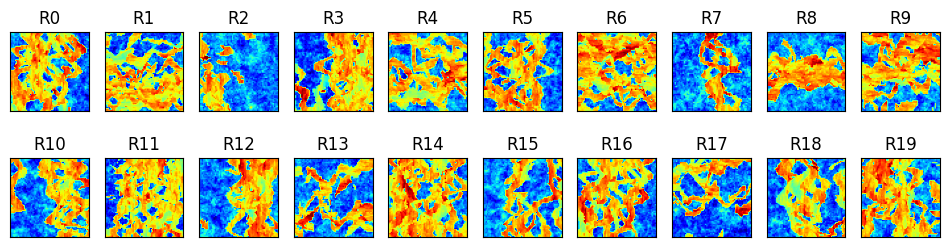

In [131]:
fig, axs = plt.subplots(2, 10, figsize=(12,3), facecolor='white')
k = 0
for i in range(2):
    for j in range(10):
        axs[i,j].imshow(perm_norm[k*3], 'jet')
        axs[i,j].set(xticks=[], yticks=[])
        axs[i,j].set(title='R{}'.format(k))
        k += 1
plt.show()

In [99]:
# Randomly generate train-test indices
split_perc = (7/10)
train_size = int(np.ceil(perm_aug.shape[0] * split_perc))
test_size  = int(np.floor(perm_aug.shape[0] * (1-split_perc)))

train_idx = np.random.choice(perm_aug.shape[0], size=train_size, replace=False)
test_idx  = np.setdiff1d(np.arange(perm_aug.shape[0]), train_idx)

# Train/Test split
X_train = perm_norm[train_idx,:,:]
X_test  = perm_norm[test_idx,:,:]

# Flatten
X_train_f = X_train.reshape(X_train.shape[0], 60*60)
X_test_f  = X_test.reshape(X_test.shape[0], 60*60)

print('X_train shape:      {} | X_test shape:       {}'.format(X_train.shape, X_test.shape))
print('X_train_flat shape: {}   | X_test_flat shape:  {}'.format(X_train_f.shape, X_test_f.shape))

X_train shape:      (210, 60, 60) | X_test shape:       (90, 60, 60)
X_train_flat shape: (210, 3600)   | X_test_flat shape:  (90, 3600)


***

#### PCA

In [100]:
n_components = 150
pca = PCA(n_components=n_components)
pca.fit(X_train_f)

# Store principal components in a DataFrame
z_pca = pd.DataFrame(pca.transform(X_train_f), columns=['PCA%i' % i for i in range(n_components)])
print('PCA transform shape: {}'.format(z_pca.shape))

PCA transform shape: (210, 150)


Variance explained by first 5 PCs: [0.085 0.071 0.062 0.054 0.044]
Total Variance explained by 150 PCAs: 0.966


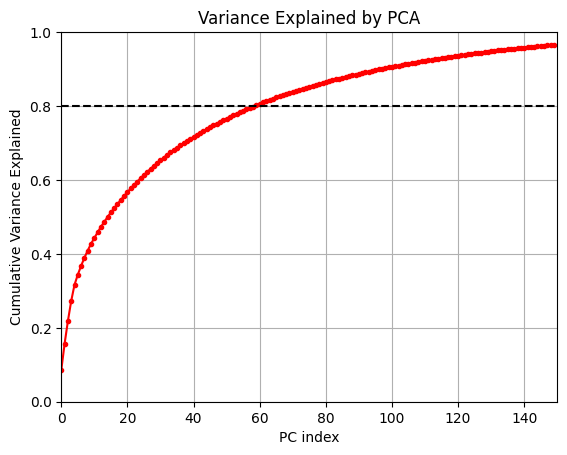

In [101]:
# Compute the variance explained by the first k principal components
print('Variance explained by first 5 PCs: {}'.format(np.round(pca.explained_variance_ratio_[:5],3)))
print('Total Variance explained by {} PCAs: {}'.format(n_components, 
                                                       np.round(pca.explained_variance_ratio_[:n_components].sum(),3)))  

plt.figure()
plt.plot(pca.explained_variance_ratio_.cumsum(), 'r.-')
plt.plot([0,n_components],[0.8,0.8], color='black',linestyle='dashed')
plt.title('Variance Explained by PCA')
plt.xlabel('PC index'); plt.ylabel('Cumulative Variance Explained')
plt.grid('on'); plt.ylim([0,1]); plt.xlim([0,n_components])
plt.show();

In [102]:
# Define how many principal components we want to keep
k = 80
pca = PCA(n_components = k)
pca.fit(X_train_f)

# Store principal components in a DataFrame
z_pca = pca.transform(X_train_f)
z_pca = pd.DataFrame(pca.transform(X_train_f), columns=['PCA%i' % i for i in range(k)])
print('PCA transform shape: {}'.format(z_pca.shape))

PCA transform shape: (210, 80)


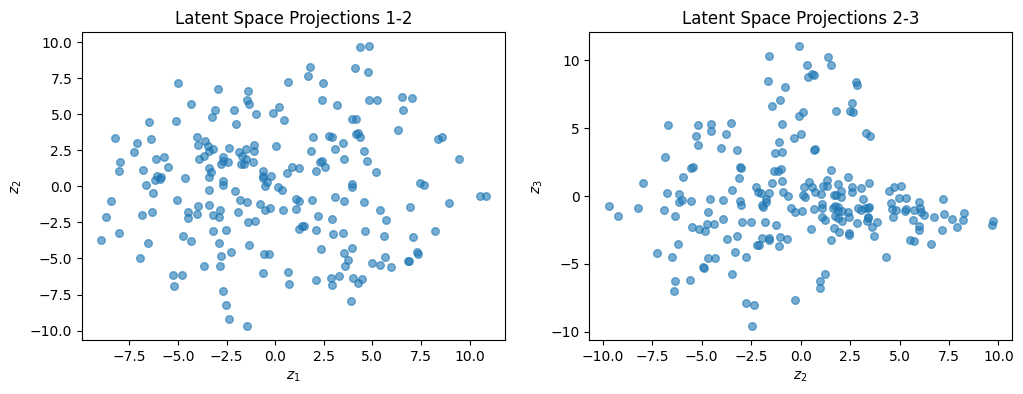

In [103]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(z_pca['PCA0'][:], z_pca['PCA1'][:], s=30, alpha=0.6)
plt.xlabel('$z_1$'); plt.ylabel('$z_2$'); plt.title('Latent Space Projections 1-2')
plt.subplot(1, 2, 2)
plt.scatter(z_pca['PCA1'][:], z_pca['PCA2'][:], s=30, alpha=0.6)
plt.xlabel('$z_2$'); plt.ylabel('$z_3$'); plt.title('Latent Space Projections 2-3')
plt.show();

In [104]:
# Compute the inverse transform onto the original dimension
X_train_f_hat = pca.inverse_transform(z_pca)
print('PCA Inverse transform shape: {}'.format(X_train_f_hat.shape))

# Reconstructed images using k basis
X_train_hat = np.reshape(X_train_f_hat, [-1, X_train.shape[1], X_train.shape[-1]])
print('PCA Inverse transform images shape: {}'.format(X_train_hat.shape))

PCA Inverse transform shape: (210, 3600)
PCA Inverse transform images shape: (210, 60, 60)


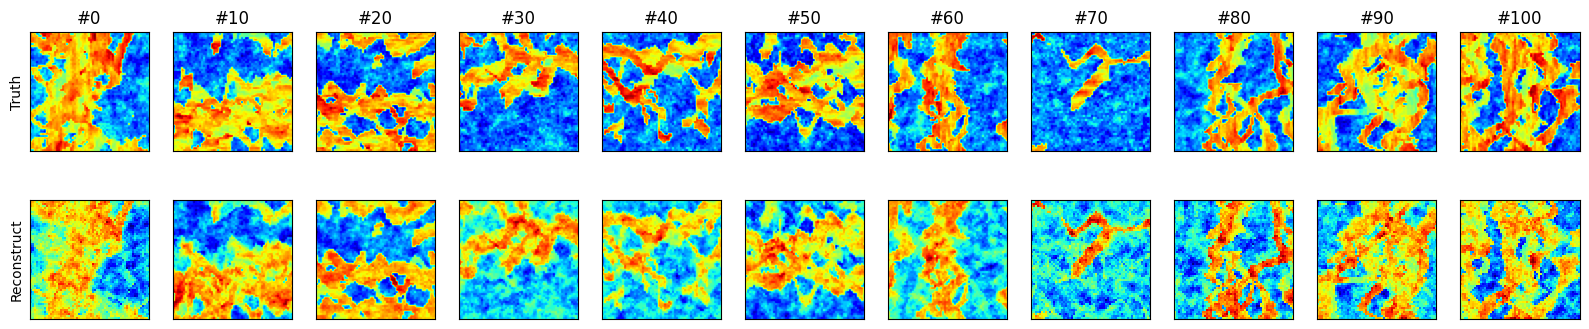

In [105]:
mult=10
nrows=11

fig, axs = plt.subplots(2, nrows, figsize=(20,4), facecolor='white')
for i in range(nrows):
    axs[0,i].imshow(X_train[i*mult], 'jet')
    axs[0,i].set(xticks=[], yticks=[]); axs[0,0].set_ylabel('Truth')
    axs[1,i].imshow(X_train_hat[i*mult], 'jet')
    axs[1,i].set(xticks=[], yticks=[]); axs[1,0].set_ylabel('Reconstruct')
    axs[0,i].set_title('#{}'.format(i*mult))

In [106]:
pca_mse = image_mse(X_train.squeeze(), X_train_hat)
pca_ssim = image_ssim(X_train.squeeze(), X_train_hat)
print('PCA: MSE={:.3f} | SSIM={:.3f}'.format(pca_mse,pca_ssim))

PCA: MSE=0.009 | SSIM=0.921


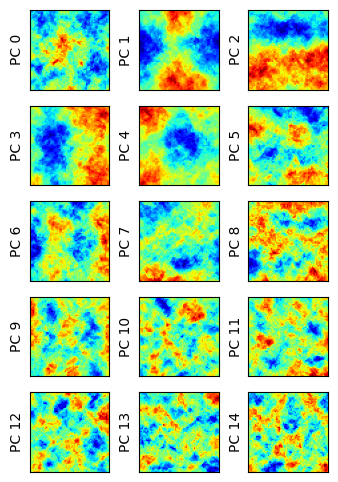

In [113]:
temp = np.array(np.matmul(z_pca.T, X_train_f)).reshape(80,60,60)

plt.figure(figsize=(4,6))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.imshow(temp[i], 'jet')
    plt.ylabel('PC {}'.format(i))
    plt.xticks([]); plt.yticks([])
plt.show()

***

#### SVD

In [114]:
U, S, VT = SVD(X_train_f, full_matrices=False)
S = np.diag(S)

print('Shapes: U={}, S={}, VT={}'.format(U.shape, S.shape, VT.shape))

Shapes: U=(210, 210), S=(210, 210), VT=(210, 3600)


IndexError: index 300 is out of bounds for axis 0 with size 210

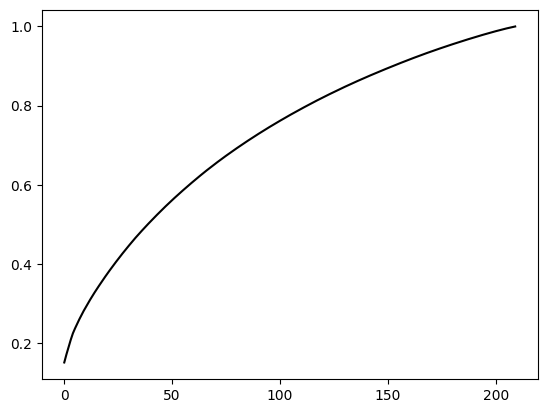

In [135]:
ks = [1, 10, 50, 100, 300]
k = 80
S_ = np.cumsum(np.diag(S))/np.sum(np.diag(S))  # make it singular value "relative"

plt.figure()
plt.plot(S_, c='k', label='All singular values')
plt.scatter(ks, S_[ks], s=50, c='r', label='Sample singular values')
plt.hlines(S_[k], 0, 350, color='k', linestyle='--', linewidth=1)
plt.scatter(k, S_[k], c='b', marker='*', s=100, label='selected (k) singular value')
for j in ks:
    plt.text(j+25, S_[j], j, bbox=my_box)
    plt.text(300, S_[k], 'k='+str(k), bbox=my_box)
plt.title('Cumulative sum of singular values'); plt.grid('on')
plt.xlabel('Singular Value index'); plt.ylabel('Cumulative Singular Value Sum')
plt.legend(loc='lower right')
plt.show();

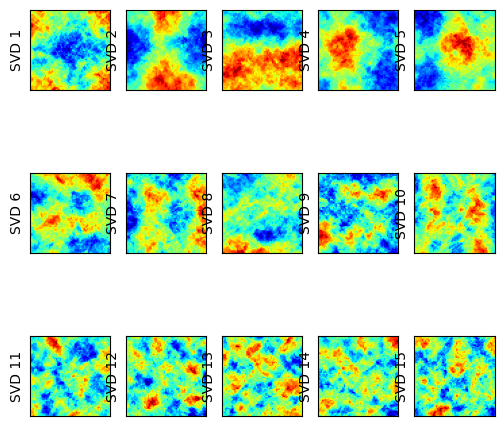

In [136]:
plt.figure(figsize=(6,6), facecolor='white')
V_k = VT[:k,:]
V_k = np.reshape(VT[:k,:], (-1,X_train.shape[1],X_train.shape[-1]))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(V_k[i], 'jet')
    plt.xticks([]); plt.yticks([])
    plt.ylabel('SVD {}'.format(i+1))
plt.show();


In [149]:
X_train_f_hat = U[:,:k] @ S[:k,:k] @ VT[:k,:]
X_train_hat   = X_train_f_hat.reshape(210,60,60)
print('X_train_hat shape: {}'.format(X_train_hat.shape))

X_train_hat shape: (210, 60, 60)


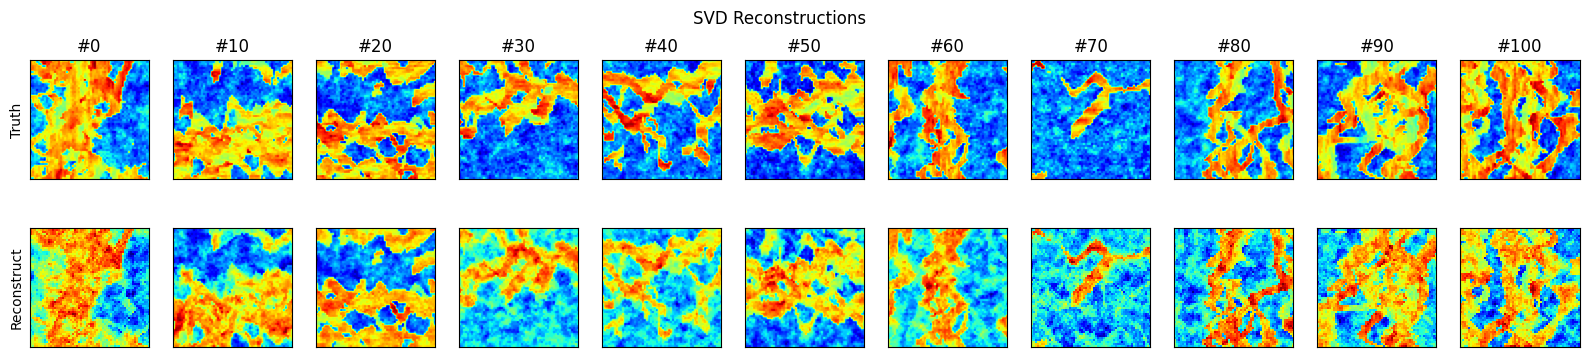

In [150]:
mult=10
nrows=11

fig, axs = plt.subplots(2, nrows, figsize=(20,4), facecolor='white')
for i in range(nrows):
    axs[0,i].imshow(X_train[i*mult], 'jet')
    axs[0,i].set(xticks=[], yticks=[]); axs[0,0].set_ylabel('Truth')
    axs[1,i].imshow(X_train_hat[i*mult], 'jet')
    axs[1,i].set(xticks=[], yticks=[]); axs[1,0].set_ylabel('Reconstruct')
    axs[0,i].set_title('#{}'.format(i*mult))
plt.suptitle('SVD Reconstructions')
plt.show();

In [139]:
svd_mse = image_mse(X_train.squeeze(), X_train_hat)
svd_ssim = image_ssim(X_train.squeeze(), X_train_hat)
print('SVD: MSE={:.3f} | SSIM={:.3f}'.format(svd_mse,svd_ssim))

SVD: MSE=0.009 | SSIM=0.921


***

#### Dictionary Learning

In [126]:
# Instatiate and fit the model to generic
n_atoms = 120

DL         = MiniBatchDictionaryLearning(n_components=n_atoms, batch_size=10, n_jobs=4)
dictionary = DL.fit(X_train_f)
atoms      = dictionary.components_
print('Dictionary Shape={} | Iterations={}'.format(atoms.shape, dictionary.n_iter_))

Dictionary Shape=(120, 3600) | Iterations=48.0


In [127]:
print('Dictionary Shape={} | Iterations={}'.format(atoms.shape, dictionary.n_iter_))

Dictionary Shape=(120, 3600) | Iterations=48.0


In [133]:
n_display_atoms = 36
atoms_   = np.reshape(atoms, (-1, X_train.shape[1], X_train.shape[2]))
atoms_k_ = atoms_[:n_display_atoms, :] 

ValueError: num must be an integer with 1 <= num <= 25, not 26

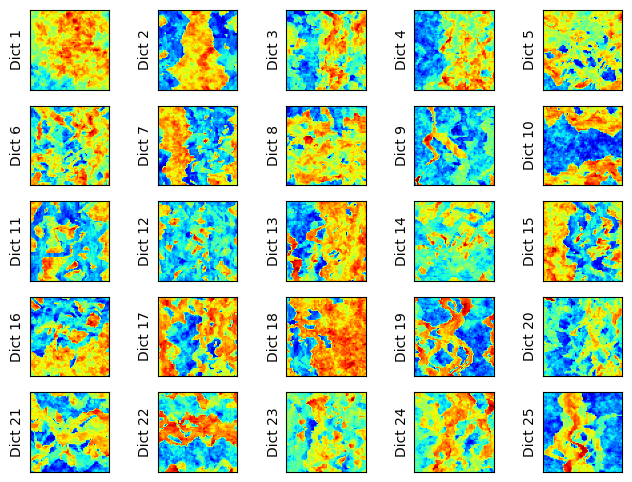

In [173]:
n_display_atoms = 36
atoms_   = np.reshape(atoms, (-1, X_train.shape[1], X_train.shape[2]))
atoms_k_ = atoms_[:n_display_atoms, :] 

plt.figure(figsize=(8,6), facecolor='white')
for i in range(n_display_atoms):
    plt.subplot(5,5,i+1)
    plt.imshow(atoms_k_[i], 'jet')
    plt.xticks([]); plt.yticks([])
    plt.ylabel('Dict {}'.format(i+1))
#plt.suptitle('Dictionary Atoms')
plt.show();

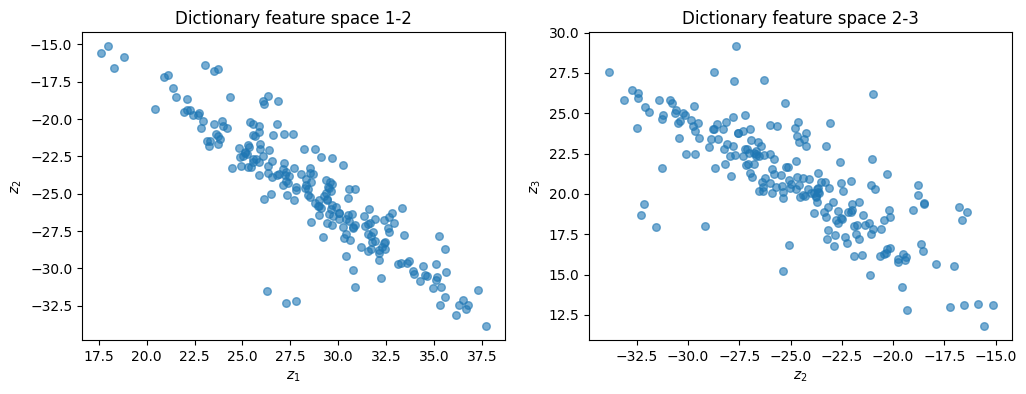

In [174]:
# Project the training data
zDL  = X_train_f @ atoms.T 

# Visualize feature space projections
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(zDL[:,0], zDL[:,1], s=30, alpha=0.6)
plt.title('Dictionary feature space 1-2')
plt.xlabel('$z_1$'); plt.ylabel('$z_2$')

plt.subplot(122)
plt.scatter(zDL[:,1], zDL[:,2], s=30, alpha=0.6)
plt.title('Dictionary feature space 2-3')
plt.xlabel('$z_2$'); plt.ylabel('$z_3$')
plt.show();

In [175]:
# Generate the sparse encoder and project onto the atoms of the dictionary
sparse_code = SparseCoder(atoms).fit_transform(X_train_f)
sparse_recs = (sparse_code @ atoms)
X_train_hat = sparse_recs.reshape(X_train.shape[0], 60, 60)

print('Sparse Encoder shape = {}'.format(sparse_code.shape))
print('Sparse Reconstruction dictionary shape = {}'.format(sparse_recs.shape))
print('X_train_hat reconstruction shape = {}'.format(X_train_hat.shape))

Sparse Encoder shape = (210, 120)
Sparse Reconstruction dictionary shape = (210, 3600)
X_train_hat reconstruction shape = (210, 60, 60)


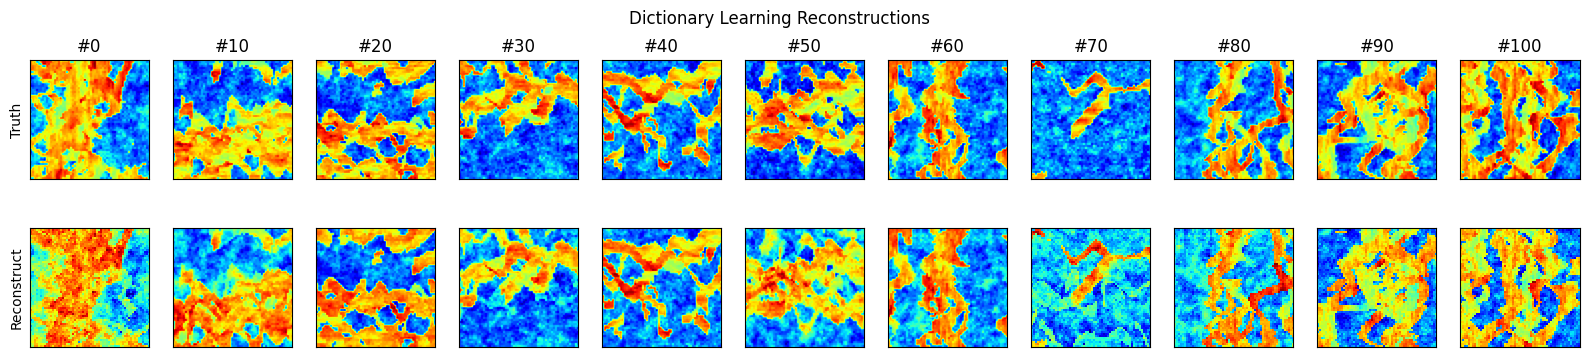

In [176]:
mult=10
nrows=11

fig, axs = plt.subplots(2, nrows, figsize=(20,4), facecolor='white')
for i in range(nrows):
    axs[0,i].imshow(X_train[i*mult], 'jet')
    axs[0,i].set(xticks=[], yticks=[]); axs[0,0].set_ylabel('Truth')
    axs[1,i].imshow(X_train_hat[i*mult], 'jet')
    axs[1,i].set(xticks=[], yticks=[]); axs[1,0].set_ylabel('Reconstruct')
    axs[0,i].set_title('#{}'.format(i*mult))
plt.suptitle('Dictionary Learning Reconstructions')
plt.show();

In [28]:
dl_mse = image_mse(X_train.squeeze(), X_train_hat)
dl_ssim = image_ssim(X_train.squeeze(), X_train_hat)
print('Dictionary Learning: MSE={:.3f} | SSIM={:.3f}'.format(dl_mse,dl_ssim))

Dictionary Learning: MSE=0.005 | SSIM=0.934


***

### DFT & DWT

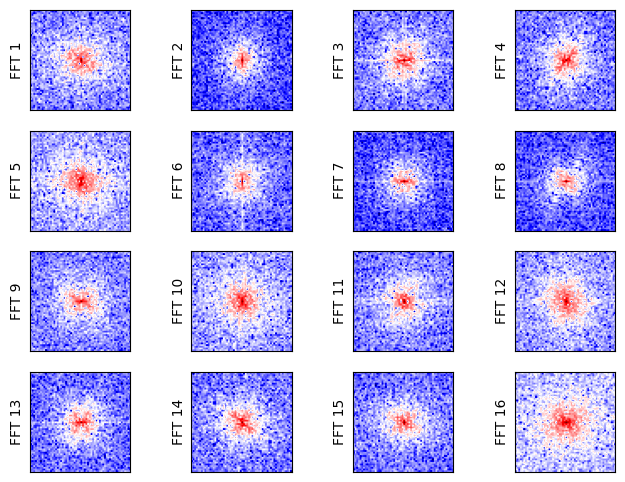

In [140]:
x_train_fft2   = FFT2(X_train)
X_train_fft2_s = SHIFT(x_train_fft2) 

# Plot the Shifted (center) FFT frequencies for each digit
n_display=16
plt.figure(figsize=(8,6), facecolor='white')
for i in range(n_display):
    plt.subplot(4,4,i+1)
    plt.imshow(np.log10(np.abs(X_train_fft2_s[i])**2), cmap='seismic')
    plt.ylabel('FFT %i' %(i+1)); plt.xticks([]); plt.yticks([])
plt.show();

Start=10, End=50


C:\Users\Misael Morales\AppData\Local\Temp\ipykernel_13676\1316673144.py:16: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(X_train_fft2_c[i])**2), cmap='seismic')


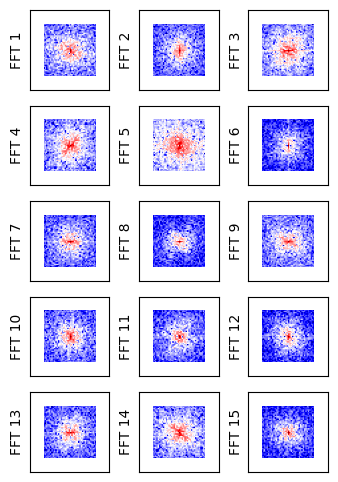

In [147]:
# Define a retention matrix (n-by-n) at the center of the 60x60 image
retain_dim    = 40
train_samples = X_train.shape[0]
center        = X_train.shape[1]
start, end    = int(center/2-retain_dim/2), int(center/2+retain_dim/2)
print('Start={}, End={}'.format(start,end))

# Create a matrix with all zeros except for central (n-by-n) square retained
X_train_fft2_c = np.zeros((train_samples,60,60), dtype=np.complex_)
X_train_fft2_c[:, start:end, start:end] = X_train_fft2_s[:, start:end, start:end]

# Plot the RETAINED, shifted FFT frequencies 
plt.figure(figsize=(4,6), facecolor='white')
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.imshow(np.log10(np.abs(X_train_fft2_c[i])**2), cmap='seismic')
    plt.ylabel('Shift FFT %i' %(i+1)); plt.xticks([]); plt.yticks([])
plt.show();

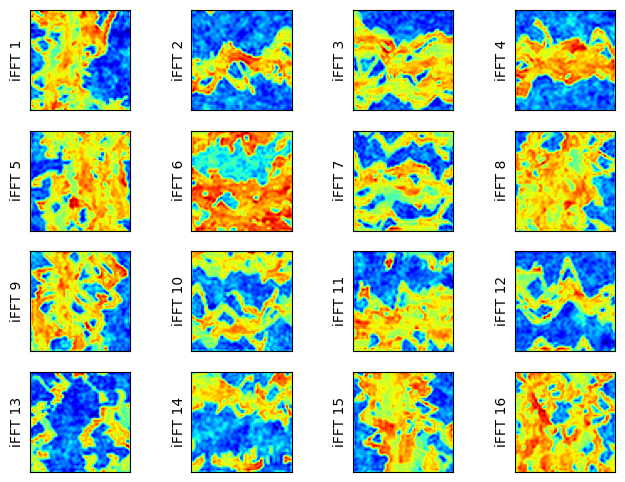

In [178]:
# Inverse-shift the centered latent-space representations
X_train_fft2_is  = iSHIFT(X_train_fft2_c) 

# Compute inverse FFT
X_train_fft2_i   = iFFT2(X_train_fft2_is)
X_train_fft2_img = X_train_fft2_i.real

# Flatten and store final 60x60 reconstructed images
X_train_fft2_i_f = X_train_fft2_img.reshape(X_train_fft2_i.shape[0],-1)
X_train_hat = X_train_fft2_img

# Plot the reconstructed images
plt.figure(figsize=(8,6), facecolor='white')
for i in range(n_display):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train_hat[i], cmap='jet')
    plt.ylabel('iFFT %i' %(i+1)); plt.xticks([]); plt.yticks([])
plt.show();

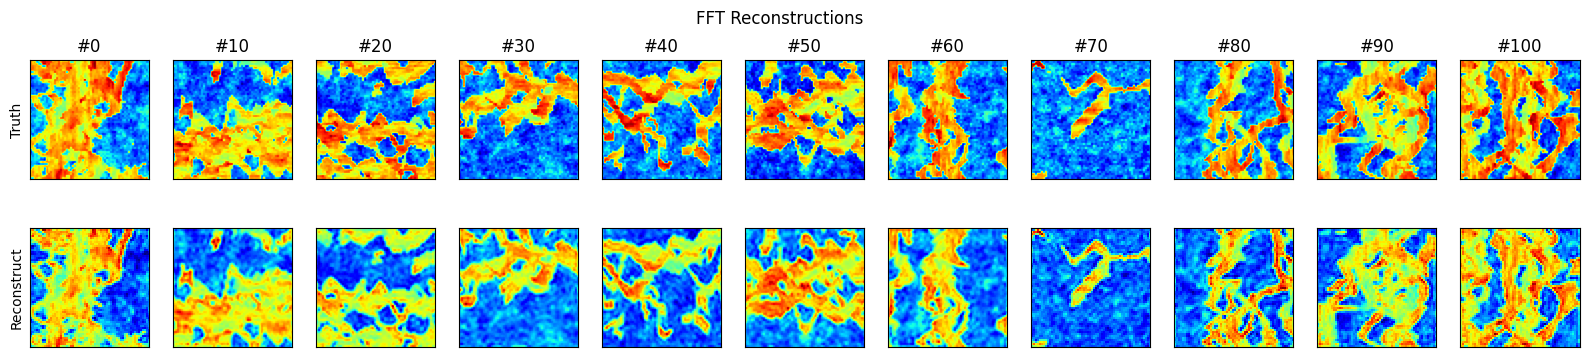

In [179]:
mult=10
nrows=11

fig, axs = plt.subplots(2, nrows, figsize=(20,4), facecolor='white')
for i in range(nrows):
    axs[0,i].imshow(X_train[i*mult], 'jet')
    axs[0,i].set(xticks=[], yticks=[]); axs[0,0].set_ylabel('Truth')
    axs[1,i].imshow(X_train_hat[i*mult], 'jet')
    axs[1,i].set(xticks=[], yticks=[]); axs[1,0].set_ylabel('Reconstruct')
    axs[0,i].set_title('#{}'.format(i*mult))
plt.suptitle('FFT Reconstructions')
plt.show();

In [182]:
fft_mse = image_mse(X_train.squeeze(), X_train_hat)
fft_ssim = image_ssim(X_train.squeeze(), X_train_hat)
print('FFT: MSE={:.3f} | SSIM={:.3f}'.format(fft_mse,fft_ssim))

FFT: MSE=0.005 | SSIM=0.957


#### 2D Discrete Wavelet Transform

In [183]:
#parameters
wavelet = 'haar'    #generating wavelet
level   = 2        #wavelet bank levels
axes_wt = (-2, -1) #wavelet

#2D Wavelet Transform
coeffs = DWT2(X_train, wavelet=wavelet, level=level, axes=axes_wt)

#print shape of the DWT coefficients
print('original image shape', X_train.shape)
print('coeffs[0].shape', coeffs[0].shape)
for i in range(level):
    for j in range(3):
        print('coeffs[%d][%d].shape:' %(i+1,j), coeffs[i+1][j].shape)   

original image shape (210, 60, 60)
coeffs[0].shape (210, 15, 15)
coeffs[1][0].shape: (210, 15, 15)
coeffs[1][1].shape: (210, 15, 15)
coeffs[1][2].shape: (210, 15, 15)
coeffs[2][0].shape: (210, 30, 30)
coeffs[2][1].shape: (210, 30, 30)
coeffs[2][2].shape: (210, 30, 30)


In [184]:
coeff_arr, coeff_slices = coeffs_to_array(coeffs, axes=axes_wt)  #array of coeffs
coeff_sort = np.sort(np.abs(coeff_arr.reshape(-1)))              #flatten & sort

#reconstruct with only k% coefficient
keep_perc = 0.3
threshold = coeff_sort[int(np.floor((1-keep_perc)*len(coeff_sort)))]
coeff_arr_t = coeff_arr * (np.abs(coeff_arr) > threshold)
coeffs_t = array_to_coeffs(coeff_arr_t, coeff_slices, output_format='wavedec2')
X_train_hat = iDWT2(coeffs_t, wavelet=wavelet) 

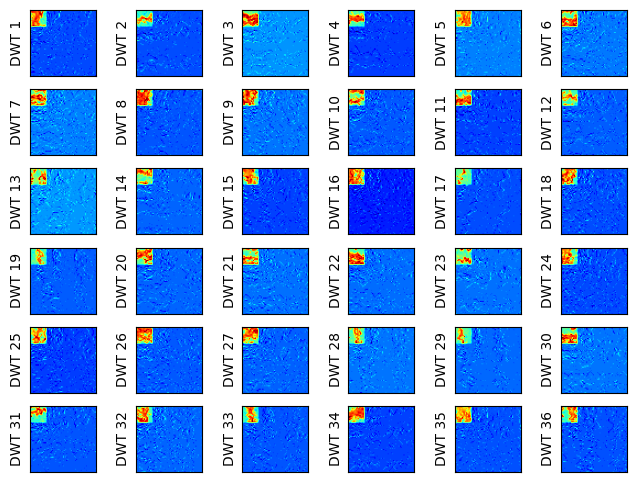

In [185]:
plt.figure(figsize=(8,6), facecolor='white')
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.imshow(coeff_arr_t[i], 'jet')
    plt.xticks([]); plt.yticks([])
    plt.ylabel('DWT {}'.format(i+1))
plt.show();

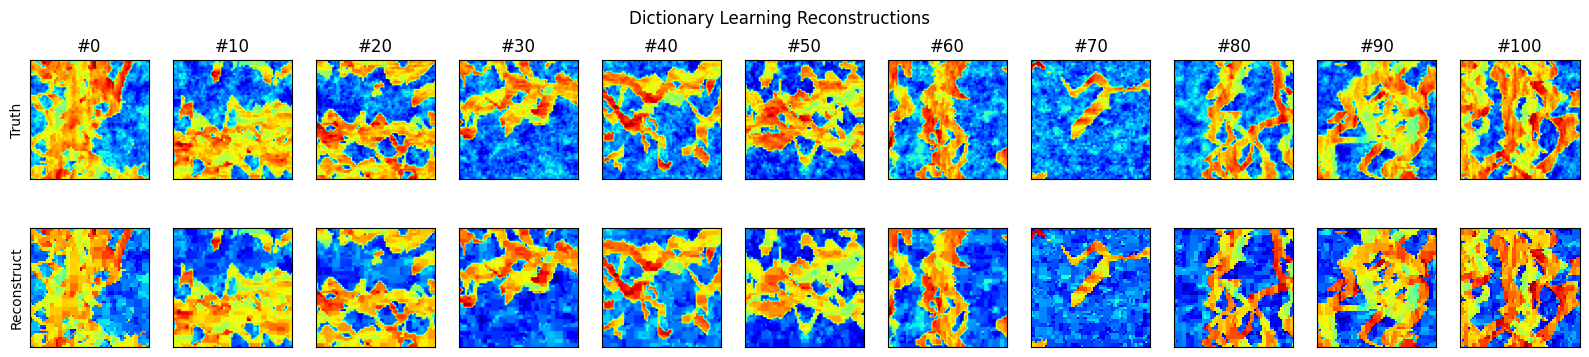

In [186]:
mult=10
nrows=11

fig, axs = plt.subplots(2, nrows, figsize=(20,4), facecolor='white')
for i in range(nrows):
    axs[0,i].imshow(X_train[i*mult], 'jet')
    axs[0,i].set(xticks=[], yticks=[]); axs[0,0].set_ylabel('Truth')
    axs[1,i].imshow(X_train_hat[i*mult], 'jet')
    axs[1,i].set(xticks=[], yticks=[]); axs[1,0].set_ylabel('Reconstruct')
    axs[0,i].set_title('#{}'.format(i*mult))
plt.suptitle('Dictionary Learning Reconstructions')
plt.show();

In [187]:
dwt_mse = image_mse(X_train.squeeze(), X_train_hat)
dwt_ssim = image_ssim(X_train.squeeze(), X_train_hat)
print('Wavelet Transform: MSE={:.3f} | SSIM={:.3f}'.format(dwt_mse,dwt_ssim))

Wavelet Transform: MSE=0.001 | SSIM=0.990


***

#### Deep Learning
- Fully-Connected AutoEncoder
- Convolutional AutoEncoder
- Variational Convolutional AutoEncoder

#### Fully-Connected AutoEncoder

Number of parameters: 1,938,804
Training time: 0.07 minutes


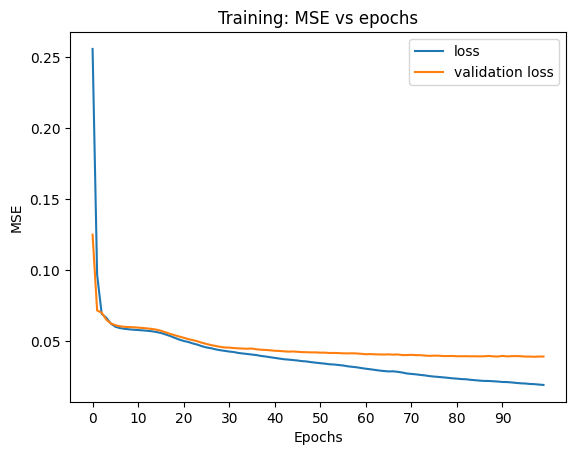

In [214]:
keras.backend.clear_session()

inp = Input(shape=(X_train_f.shape[-1],))
x   = Dense(units=256, activation='relu')(inp)
x   = Dense(units=128, activation='relu')(x)
enc = Dense(units=100,  activation='relu')(x)
x   = Dense(units=128, activation='relu')(enc) 
x   = Dense(units=256, activation='relu')(x) 
dec = Dense(units=X_train_f.shape[-1])(x)

fcnn_encoder = Model(inp, enc)
fcnn_model   = Model(inp, dec)
print('Number of parameters: {:,}'.format(fcnn_model.count_params()))

# compile model
fcnn_model.compile(optimizer = 'adam', 
                    loss     = 'mse', 
                    metrics  = ['mse'])

# fit model
start = time()
fit = fcnn_model.fit(X_train_f, X_train_f,
                    shuffle          = True, 
                    epochs           = 100, 
                    batch_size       = 40, 
                    validation_split = 0.25,
                    verbose          = 0)
train_time = time()-start
print('Training time: {:.2f} minutes'.format(train_time/60))
plot_loss(fit)

In [215]:
# train/test predictions
train_pred = fcnn_model.predict(X_train_f).astype('float64').reshape(train_size,60,60)
test_pred  = fcnn_model.predict(X_test_f).astype('float64').reshape(test_size,60,60)

mse_train, ssim_train = image_mse(X_train, train_pred), image_ssim(X_train, train_pred)
mse_test, ssim_test   = image_mse(X_test, test_pred), image_ssim(X_test, test_pred)

print('Training - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_train, ssim_train))
print('Testing  - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_test, ssim_test))

3/3 [==============================] - 0s 2ms/step
Training - MSE: 0.024 | MSSIM: 0.753
Testing  - MSE: 0.039 | MSSIM: 0.574


7/7 [==============================] - 0s 997us/step
Latent Space dimension: (210, 100)


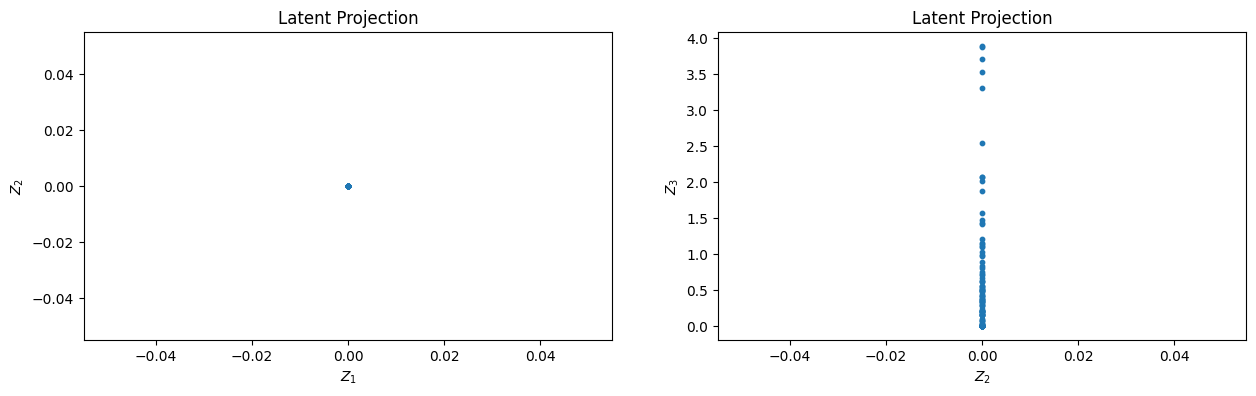

In [216]:
# latent space representation
fc_latent = fcnn_encoder.predict(X_train_f)
print('Latent Space dimension: {}'.format(fc_latent.shape))

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.scatter(fc_latent[:,0], fc_latent[:,1], s=10)
plt.title('Latent Projection'); plt.xlabel('$Z_1$'); plt.ylabel('$Z_2$')
plt.subplot(122)
plt.scatter(fc_latent[:,1], fc_latent[:,2], s=10)
plt.title('Latent Projection'); plt.xlabel('$Z_2$'); plt.ylabel('$Z_3$')
plt.show();

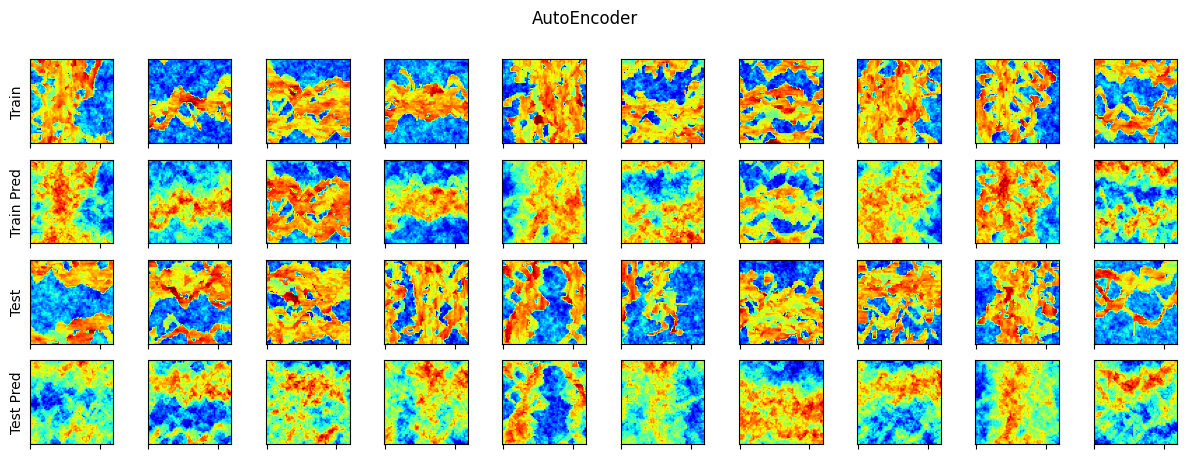

In [217]:
# visualize results
data = [X_train, train_pred, X_test, test_pred]
plot_results(data, 'AutoEncoder')

#### Convolutional AutoEncoder

In [222]:
X_train_img = np.expand_dims(X_train, -1)
X_test_img  = np.expand_dims(X_test, -1)
print('X_train_img shape: {}'.format(X_train_img.shape))
print('X_test_img shape:  {}'.format(X_test_img.shape))

X_train_img shape: (210, 60, 60, 1)
X_test_img shape:  (90, 60, 60, 1)


Number of parameters: 1,461,349
Training time: 0.10 minutes


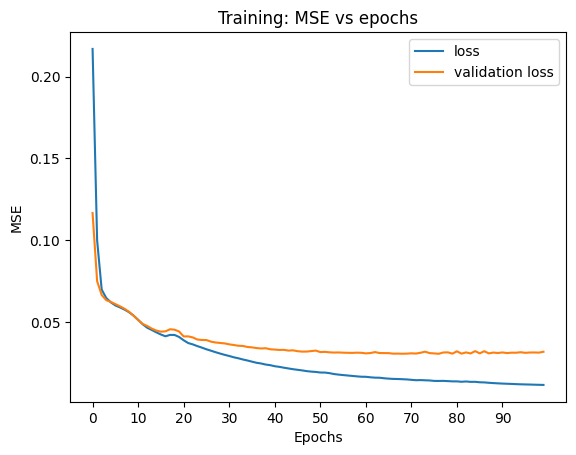

In [223]:
keras.backend.clear_session()

inp = Input(shape=(60,60,1))

x = Conv2D(8, (3,3), padding='same', activation='relu')(inp)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)

shape_before_flatten = keras.backend.int_shape(x)[1:]
x = Flatten(name='latent_dim')(x)
enc = Dense(100, name='enc')(x)
x = Dense(np.prod(shape_before_flatten))(enc)
x = Reshape(shape_before_flatten)(x)

x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)

out = Conv2D(1, (3,3), padding='same', activation='relu')(x)

cnn_model = Model(inp,out)
cnn_encoder = Model(inp, enc)
print('Number of parameters: {:,}'.format(cnn_model.count_params()))

# compile model
cnn_model.compile(optimizer = 'adam',
                    loss     = 'mse', 
                    metrics  = ['mse'])

# fit model
start = time()
fit = cnn_model.fit(X_train_img, X_train_img,
                    shuffle          = True, 
                    epochs           = 100, 
                    batch_size       = 32, 
                    validation_split = 0.25,
                    verbose          = 0)
train_time = time()-start
print('Training time: {:.2f} minutes'.format(train_time/60))
plot_loss(fit)

In [224]:
# train/test predictions
train_pred = cnn_model.predict(X_train_img).astype('float64').squeeze()
test_pred  = cnn_model.predict(X_test_img).astype('float64').squeeze()

mse_train, ssim_train = image_mse(X_train, train_pred), image_ssim(X_train, train_pred)
mse_test, ssim_test   = image_mse(X_test, test_pred), image_ssim(X_test, test_pred)

print('Training - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_train, ssim_train))
print('Testing  - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_test, ssim_test))

3/3 [==============================] - 0s 2ms/step
Training - MSE: 0.017 | MSSIM: 0.839
Testing  - MSE: 0.031 | MSSIM: 0.686


7/7 [==============================] - 0s 1ms/step
Latent Space dimension: (210, 100)


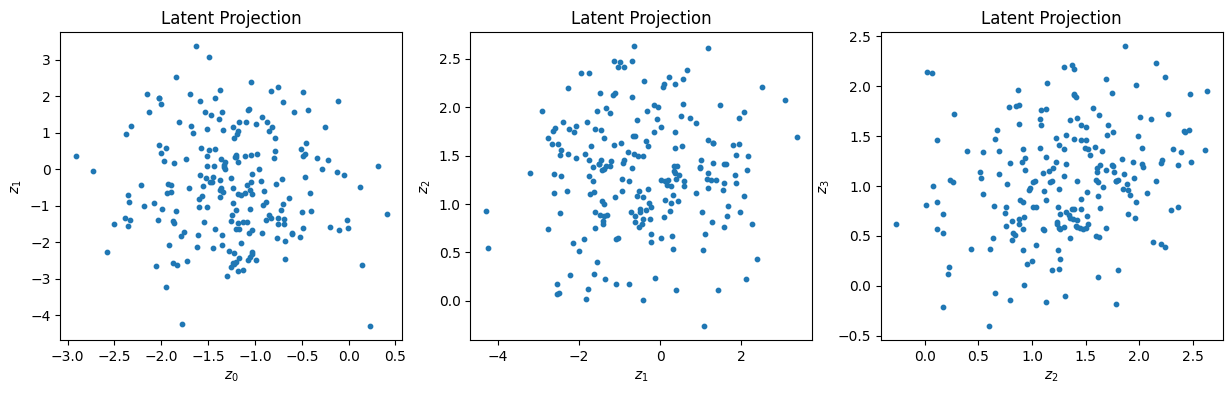

In [225]:
# latent space representation
cnn_latent = cnn_encoder.predict(X_train)
print('Latent Space dimension: {}'.format(cnn_latent.shape))

subs = 3
plt.figure(figsize=(15,4))
for i in range(subs):
    plt.subplot(1,subs,i+1)
    plt.scatter(cnn_latent[:,i], cnn_latent[:,i+1], s=10)
    plt.title('Latent Projection')
    plt.xlabel('$z_{}$'.format(i)); plt.ylabel('$z_{}$'.format(i+1))
plt.show();

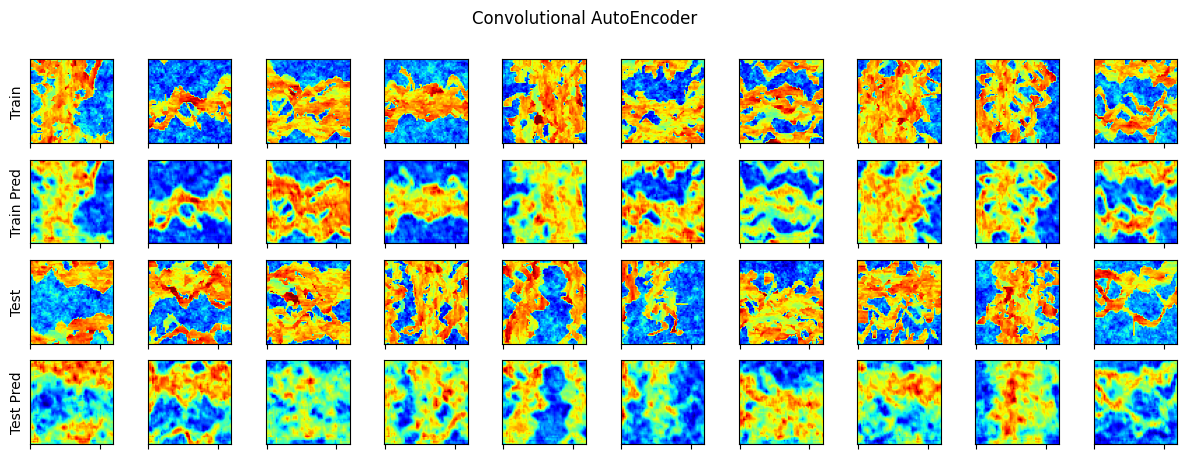

In [226]:
# visualize results
data = [X_train_img, train_pred, X_test_img, test_pred]
plot_results(data, 'Convolutional AutoEncoder')

#### Variational AutoEncoder

In [228]:
def sample(args):
    mean, sigma = args
    epsilon = keras.backend.random_normal(shape=(keras.backend.shape(mean)[0],2), mean=0.0, stddev=1.0)
    return mean + keras.backend.exp(sigma)*epsilon

In [229]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        reconstruction_loss = keras.backend.mean(keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss
    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss
    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss
    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)
        loss = reconstruction_loss + kl_loss
        return loss
    return vae_loss

Number of parameters: 7,231,025
Training time: 0.25 minutes


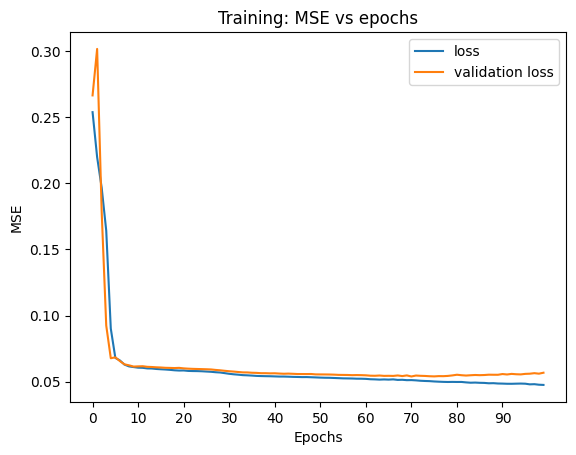

In [241]:
keras.backend.clear_session()

# Encoder
inp = Input(shape=(60,60,1))
x = Conv2D(128, (3,3), padding='same', activation='relu')(inp)
x = MaxPooling2D((2,2))(x)
x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D((2,2))(x)
shape_before_flatten = keras.backend.int_shape(x)[1:]
x = Flatten(name='latent_dim')(x)
mean, sigma  = Dense(2)(x), Dense(2)(x)
enc = Lambda(sample)([mean, sigma])

# Decoder
z_inp = Input(shape=(2,))
x = Dense(100, activation='relu')(z_inp)
x = Dense(np.prod(shape_before_flatten), activation='relu')(x)
x = Reshape(shape_before_flatten)(x)
x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = UpSampling2D((2,2))(x)
out = Conv2D(1, (3,3), padding='same', activation='relu')(x)

# VAE
vae_encoder = Model(inp, enc)
vae_decoder = Model(z_inp, out)
vae_model   = Model(inp, vae_decoder(vae_encoder(inp)))
print('Number of parameters: {:,}'.format(vae_model.count_params()))

# compile model
vae_model.compile(optimizer = 'adam',
                    loss    = 'mse',  #loss_func(mean,sigma)
                    metrics = ['mse'])

# fit model
start = time()
fit = vae_model.fit(X_train_img, X_train_img,
                    shuffle          = True, 
                    epochs           = 100, 
                    batch_size       = 32, 
                    validation_split = 0.25,
                    verbose          = 0)
train_time = time()-start
print('Training time: {:.2f} minutes'.format(train_time/60))
plot_loss(fit)

In [242]:
# train/test predictions
train_pred = vae_model.predict(X_train_img).astype('float64').squeeze()
test_pred  = vae_model.predict(X_test_img).astype('float64').squeeze()

mse_train, ssim_train = image_mse(X_train, train_pred), image_ssim(X_train, train_pred)
mse_test, ssim_test   = image_mse(X_test, test_pred), image_ssim(X_test, test_pred)

print('Training - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_train, ssim_train))
print('Testing  - MSE: {:.3f} | MSSIM: {:.3f}'.format(mse_test, ssim_test))

3/3 [==============================] - 0s 87ms/step
Training - MSE: 0.050 | MSSIM: 0.371
Testing  - MSE: 0.056 | MSSIM: 0.294


7/7 [==============================] - 0s 2ms/step
Latent Space dimension: (210, 2)


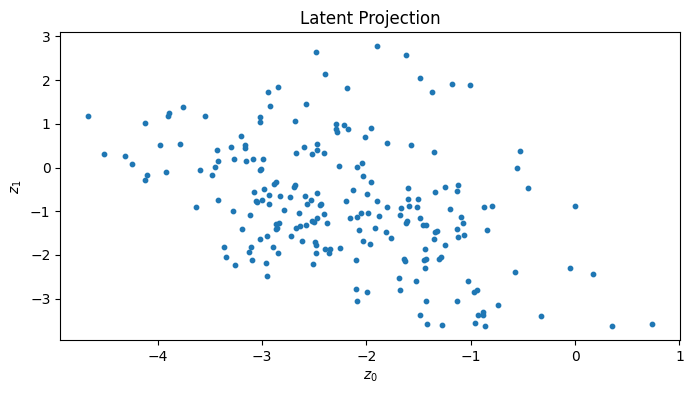

In [243]:
# latent space representation
vae_latent = vae_encoder.predict(X_train_img)
print('Latent Space dimension: {}'.format(vae_latent.shape))

subs = 1
plt.figure(figsize=(8,4))
for i in range(subs):
    plt.subplot(1,subs,i+1)
    plt.scatter(vae_latent[:,i], vae_latent[:,i+1], s=10)
    plt.title('Latent Projection')
    plt.xlabel('$z_{}$'.format(i)); plt.ylabel('$z_{}$'.format(i+1))
plt.show();

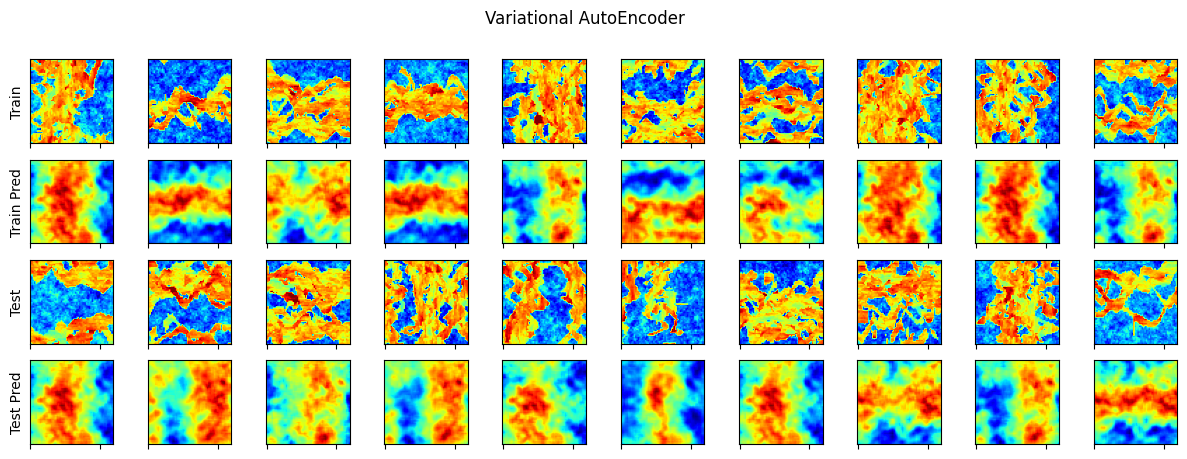

In [244]:
# visualize results
data = [X_train_img, train_pred, X_test_img, test_pred]
plot_results(data, 'Variational AutoEncoder')

7/7 [==============================] - 0s 1ms/step
(210, 60, 60) (210, 10, 10)


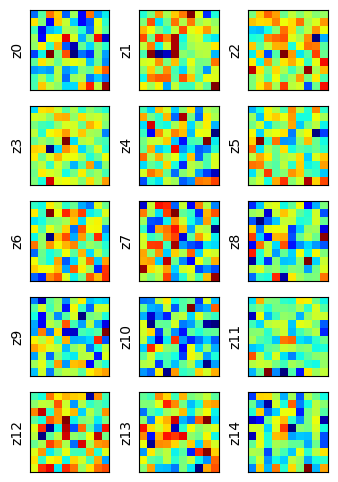

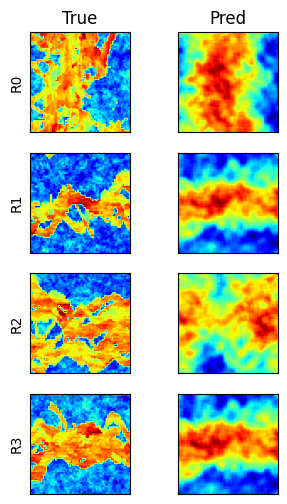

In [245]:
z = cnn_encoder.predict(X_train_img).reshape(210,10,10)
x = train_pred

print(x.shape, z.shape)

plt.figure(figsize=(4,6))
for i in range(15):
    plt.subplot(5,3,i+1)
    plt.imshow(z[i], 'jet')
    plt.ylabel('z{}'.format(i))
    plt.xticks([]); plt.yticks([])
plt.show()

titles = ['True', 'Pred']
fig, axs = plt.subplots(4, 2, figsize=(3.5,6), facecolor='white')
for i in range(4):
    true, pred = X_train[i], x[i]
    axs[i,0].imshow(true, 'jet')
    axs[i,1].imshow(pred, 'jet')
    axs[i,0].set(ylabel='R{}'.format(i))
    for j in range(2):
        axs[i,j].set(xticks=[], yticks=[])
        axs[0,j].set(title=titles[j])
plt.show()

# END